In [9]:
%reload_ext autoreload
%autoreload 2
from helpers import *
from spice_net import *
import numpy as np
import matplotlib.pyplot as plt

#### Generate the dataset

In [29]:
# Generate N random points
N = 100
split = 0.6
pts = np.random.rand(N, 2)

# Split into training and testing datasets
np.random.shuffle(pts)
train_x, test_x = pts[:int(N*split),:], pts[int(N*split):,:]

# Generate categories with nonlinear decision boundary
m = np.random.random()
b=0
decision_bound = lambda x: m*x+b

mask = pts[:, 1] > decision_bound(pts[:, 0])
pos = pts[mask]
neg = pts[~mask]
train_y = np.vstack((mask[:int(N*split)], ~mask[:int(N*split)])).T.astype(int)
test_y = np.vstack((mask[int(N*split):], ~mask[int(N*split):])).T.astype(int)

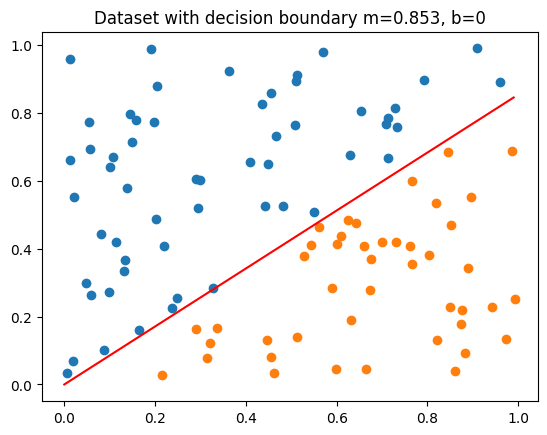

In [31]:
# Visualize dataset
plt.scatter(*pos.T)
plt.scatter(*neg.T)
xs = np.arange(0, 1, 0.01)
plt.plot(xs, decision_bound(xs), 'r')
plt.title(fr'Dataset with decision boundary m={round(m, 3)}, b={round(b, 3)}')
plt.show()

#### Generate random linear resistive network

In [10]:
# Parameters
nodes = 8
edge_prob = .8
diode_prob = 0

con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=False)
diodes, res = 0, 0
for u, v in con_graph.edges():
    if np.random.rand() < diode_prob:
        diodes += 1
        con_graph[u][v]['type'] = 'diode'
        con_graph[u][v]['weight'] = 1./np.random.rand() / nodes
    else:
        con_graph[u][v]['type'] = 'resistor'
        con_graph[u][v]['weight'] = 1./np.random.rand() / nodes
        res += 1

print('Num edges:', diodes + res)
print('Num purely resistor:', res)
print('Num diodes:', diodes)

in_nodes = 2
out_nodes = 2
node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])
node_cfg

Num edges: 23
Num purely resistor: 23
Num diodes: 0


(array([[0, 4],
        [6, 3]]),
 array([[2, 5],
        [7, 1]]))

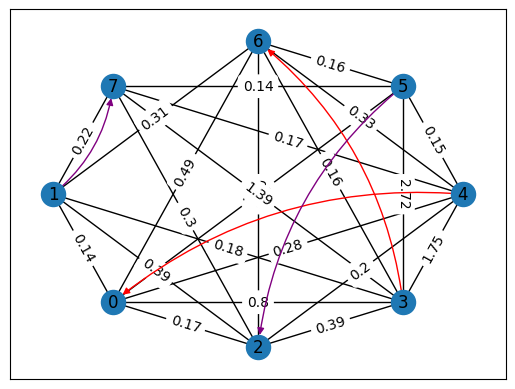

In [11]:
lin = NonLinearNetwork('untrained_class', con_graph, node_cfg)

visualize(lin)

#### Train both networks

In [12]:
augmented = np.hstack((train_x, np.ones((train_x.shape[0], 1))))
dset = train_x

In [14]:
# Train linear network
epochs = 100

alpha = 1e-1
eta = 1e-3
gamma = alpha / eta / 2

trained_lin, loss, updates, weights = train(lin.copy('lin_class'), dset, train_y, epochs, gamma=gamma, eta=eta)

Note: can't find the initialization file spinit.
Unsupported Ngspice version 38


Epoch 1: 0.49122639116662553
Epoch 2: 0.4563339118111211
Epoch 3: 0.4240777375640106
Epoch 4: 0.40787550208971446
Epoch 5: 0.39283474019351233
Epoch 6: 0.379230273259004
Epoch 7: 0.36577006213890506
Epoch 8: 0.35228187921675685
Epoch 9: 0.33813453055284387
Epoch 10: 0.32422087483106155
Epoch 11: 0.3137784199699026
Epoch 12: 0.30377539406259074
Epoch 13: 0.2943805299241697
Epoch 14: 0.28496395570751615
Epoch 15: 0.27623485790179436
Epoch 16: 0.2687622462635041
Epoch 17: 0.26150662030025507
Epoch 18: 0.25413602586779127
Epoch 19: 0.24795800201964838
Epoch 20: 0.24181243995461363
Epoch 21: 0.23597120311415268
Epoch 22: 0.23330337035910706
Epoch 23: 0.23055185936369246
Epoch 24: 0.22906548717022615
Epoch 25: 0.2277008446329438
Epoch 26: 0.22716453545291013
Epoch 27: 0.2242523921304327
Epoch 28: 0.22310818318407497
Epoch 29: 0.22288371058809833
Epoch 30: 0.22003376300568434
Epoch 31: 0.2186350477122021
Epoch 32: 0.21742861018087156
Epoch 33: 0.21621285059603415
Epoch 34: 0.2144518382390889


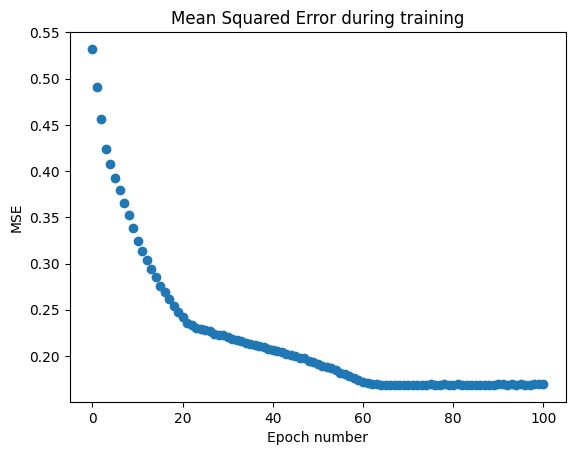

In [15]:
plt.scatter(np.arange(loss.size), loss)
plt.title('Mean Squared Error during training')
plt.xlabel('Epoch number')
plt.ylabel('MSE')
plt.show()

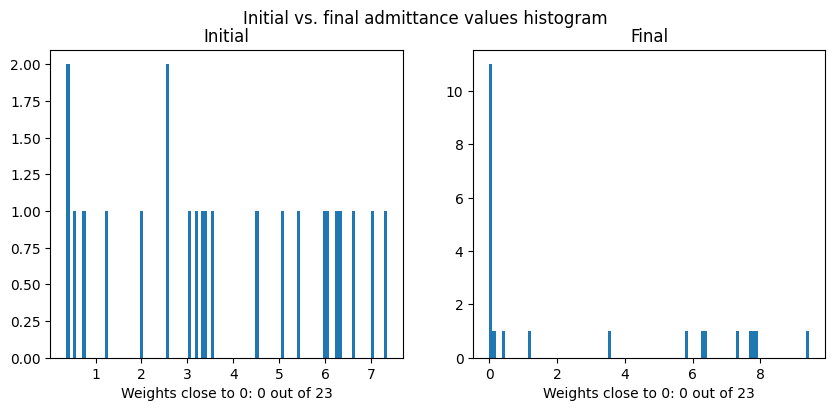

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(1./weights[0, -1], bins=100)
axs[0].set_title('Initial')
axs[0].set_xlabel(f'Weights close to 0: {np.sum(np.isclose(weights[0, -1], 1./trained_nonlin.epsilon))} out of {weights[0, -1].size}')
axs[1].hist(1./weights[-1, -1], bins=100)
axs[1].set_title('Final')
axs[1].set_xlabel(f'Weights close to 0: {np.sum(np.isclose(weights[0, -1], 1./trained_nonlin.epsilon))} out of {weights[0, -1].size}')
fig.suptitle('Initial vs. final admittance values histogram')
plt.show()

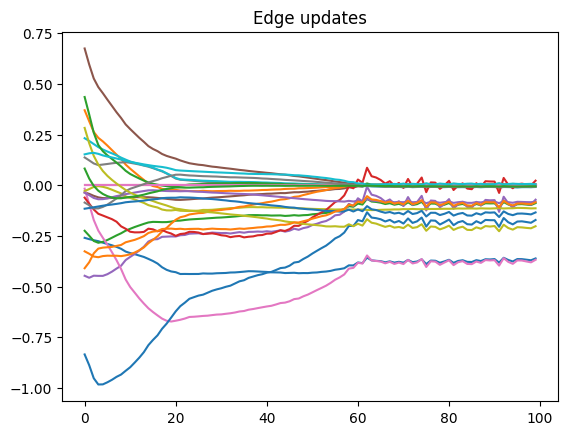

In [18]:
# plt.plot(updates.reshape(-1, updates.shape[-1]))
# plt.plot(np.clip(updates.reshape(-1, updates.shape[-1]), -.5, .5))
plt.plot(np.clip(updates.sum(axis=1), -1, 1))
plt.title('Edge updates')
plt.show()

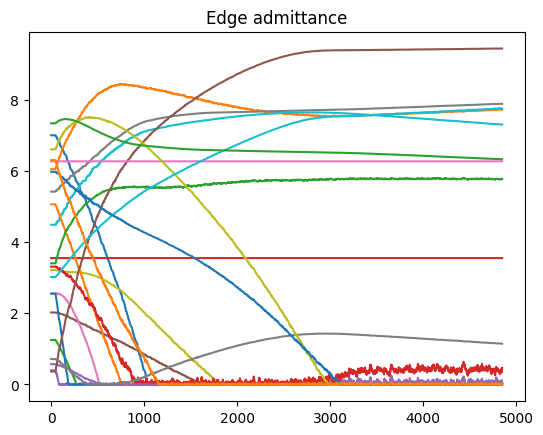

In [19]:
# plt.plot(1./weights.reshape(-1, weights.shape[-1]))
plt.plot(np.clip(1./weights.reshape(-1, weights.shape[-1]), -1, np.inf))
plt.title('Edge admittance')
plt.show()

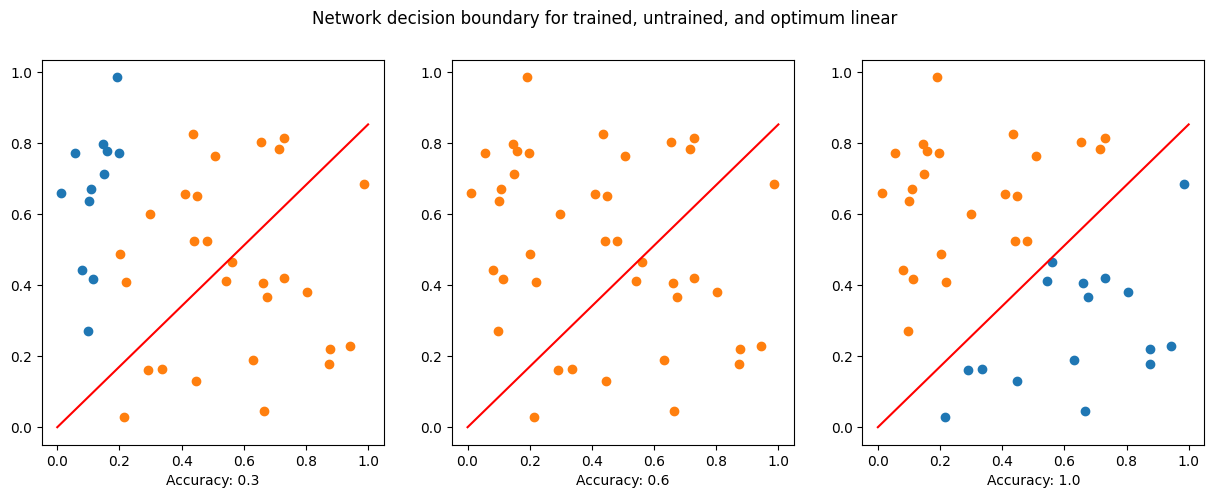

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))


untrained_sol = np.argmax(lin.predict(test_x).squeeze(), axis=1)
trained_sol = np.argmax(trained_lin.predict(test_x).squeeze(), axis=1)
analytic_sol = np.argmax(test_x @ np.linalg.inv(train_x.T @ train_x) @ train_x.T @ train_y, axis=1)
xs = np.linspace(0, 1, 10)

axs[0].scatter(*test_x[untrained_sol.astype(bool)].T)
axs[0].scatter(*test_x[~untrained_sol.astype(bool)].T)
axs[0].plot(xs, decision_bound(xs), 'r')
axs[0].set_xlabel(f'Accuracy: {np.sum(test_y[:,1] == untrained_sol) / len(test_x)}')

axs[1].scatter(*test_x[trained_sol.astype(bool)].T)
axs[1].scatter(*test_x[~trained_sol.astype(bool)].T)
axs[1].plot(xs, decision_bound(xs), 'r')
axs[1].set_xlabel(f'Accuracy: {np.sum(test_y[:,1] == trained_sol) / len(test_x)}')

axs[2].scatter(*test_x[analytic_sol.astype(bool)].T)
axs[2].scatter(*test_x[~analytic_sol.astype(bool)].T)
axs[2].plot(xs, decision_bound(xs), 'r')
axs[2].set_xlabel(f'Accuracy: {np.sum(test_y[:,1] == analytic_sol) / len(test_x)}')

fig.suptitle(f'Network decision boundary for trained, untrained, and optimum linear')
plt.show()

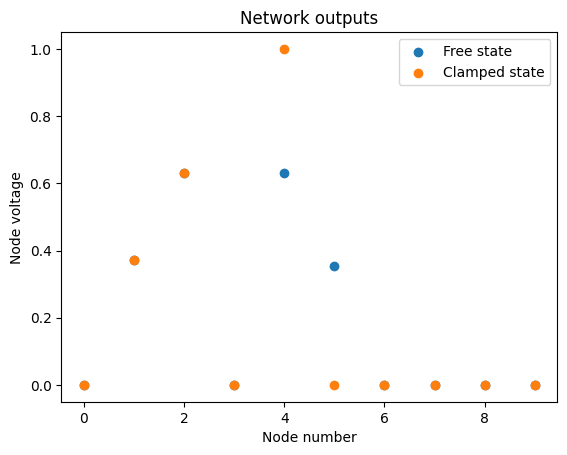

In [326]:
# Compare free and clamped results on a single input
plt.scatter(np.arange(10), trained_lin.solve(train_x[0]))
plt.scatter(np.arange(10), trained_lin.solve(train_x[0], train_y[0]))
plt.title('Network outputs')
plt.xlabel('Node number')
plt.ylabel('Node voltage')
plt.legend(['Free state', 'Clamped state'])